# Sparse Ising Model on MNIST

In [34]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from isax import (
    BlockGraph,
    Edge,
    IsingModel,
    IsingSampler,
    Node,
    sample_chain,
    SamplingArgs,
)
from torchvision import datasets

In [35]:
train_dataset = datasets.MNIST(root="/tmp/mnist", train=True, download=True)
test_dataset = datasets.MNIST(root="/tmp/mnist", train=False, download=True)

train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# Binarize images
train_images = (train_images > 127).astype(np.int32)
test_images = (test_images > 127).astype(np.int32)

# Flatten to vectors
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

target_classes = [0, 1]
train_mask = np.isin(train_labels, target_classes)
test_mask = np.isin(test_labels, target_classes)

train_images = jnp.array(train_images[train_mask])
train_labels = jnp.array(train_labels[train_mask])
test_images = jnp.array(test_images[test_mask])
test_labels = jnp.array(test_labels[test_mask])

print(f"Train: {train_images.shape}, Test: {test_images.shape}")

Train: (12665, 784), Test: (2115, 784)


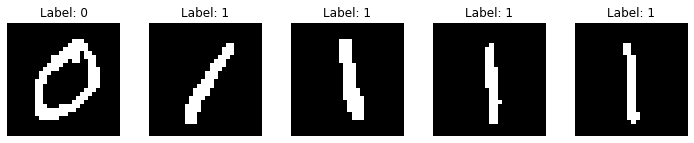

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {train_labels[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [37]:
n_visible = 28 * 28
n_hidden = 200
n_total = n_visible + n_hidden

k_connections = 50  # each hidden unit connects to 50 random visible units

key = jax.random.key(42)

visible_nodes = [Node() for _ in range(n_visible)]
hidden_nodes = [Node() for _ in range(n_hidden)]

edges = []
key, subkey = jax.random.split(key)
for h_idx, h in enumerate(hidden_nodes):
    visible_indices = np.random.choice(n_visible, size=(k_connections,), replace=False)
    for v_idx in visible_indices:
        edges.append(Edge(visible_nodes[int(v_idx)], h))

n_edges = len(edges)
print(f"Sparse: {n_edges} (vs {n_visible * n_hidden} for RBM)")
print(f"Sparsity: {n_edges / (n_visible * n_hidden) * 100:.1f}%")

blocks = [visible_nodes, hidden_nodes]
graph = BlockGraph(blocks, edges)
params = graph.get_sampling_params()
edge_indices, edge_mask = graph.get_edge_structure()

Sparse: 10000 (vs 156800 for RBM)
Sparsity: 6.4%


In [38]:
key, subkey = jax.random.split(key)
init_weights = jax.random.normal(subkey, (n_edges,)) * 0.01

data_mean = jnp.mean(train_images, axis=0)
eps = 1e-6
visible_biases = jnp.log((data_mean + eps) / (1 - data_mean + eps)) * 0.5
hidden_biases = jnp.zeros(n_hidden)
init_biases = jnp.concatenate([visible_biases, hidden_biases])

model = IsingModel(weights=init_weights, biases=init_biases)

In [39]:
@jax.jit
def data_to_spins(data):
    return 2 * data - 1


@jax.jit
def spins_to_data(spins):
    return (spins + 1) // 2


sampler = IsingSampler()

# Positive phase: only sample hidden (block 1), visible clamped
pos_sampling_args = SamplingArgs(
    gibbs_steps=200,
    blocks_to_sample=[1],
    data=params,
)

# Negative phase: sample both blocks freely
neg_sampling_args = SamplingArgs(
    gibbs_steps=400,
    blocks_to_sample=[0, 1],
    data=params,
)

In [40]:
def cd_loss(
    weights,
    biases,
    data_batch,
    key,
):
    model = IsingModel(weights=weights, biases=biases)
    batch_size = data_batch.shape[0]

    visible_spins = data_to_spins(data_batch)

    key, subkey = jax.random.split(key)
    hidden_init = jax.random.choice(subkey, jnp.array([-1, 1]), (batch_size, n_hidden))

    def sample_positive(visible, hidden, k):
        states = sample_chain(
            [visible, hidden],
            [sampler, sampler],
            model,
            pos_sampling_args,
            jax.random.fold_in(k, 0),
        )
        return states[0][-1], states[1][-1]

    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, batch_size)
    v_pos, h_pos = jax.vmap(sample_positive)(visible_spins, hidden_init, keys)

    def sample_negative(visible, hidden, k):
        states = sample_chain(
            [visible, hidden],
            [sampler, sampler],
            model,
            neg_sampling_args,
            jax.random.fold_in(k, 1),
        )
        return states[0][-1], states[1][-1]

    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, batch_size)
    v_neg, h_neg = jax.vmap(sample_negative)(v_pos, h_pos, keys)

    def compute_energy(v, h):
        state = jnp.concatenate([v, h])
        return model.energy(state, edge_indices, edge_mask)

    e_pos = jax.vmap(compute_energy)(v_pos, h_pos)
    e_neg = jax.vmap(compute_energy)(v_neg, h_neg)

    return jnp.mean(e_pos) - jnp.mean(e_neg)


@eqx.filter_jit
def cd_step(weights, biases, opt_state, optimizer, data_batch, key):
    loss, (grad_w, grad_b) = jax.value_and_grad(cd_loss, argnums=(0, 1))(
        weights, biases, data_batch, key
    )

    updates_w, opt_state_w = optimizer.update(grad_w, opt_state[0], weights)
    updates_b, opt_state_b = optimizer.update(grad_b, opt_state[1], biases)

    new_weights = optax.apply_updates(weights, updates_w)
    new_biases = optax.apply_updates(biases, updates_b)

    return new_weights, new_biases, (opt_state_w, opt_state_b), loss

In [41]:
batch_size = 64
n_epochs = 12
learning_rate = 0.005

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = (optimizer.init(model.weights), optimizer.init(model.biases))

weights = model.weights
biases = model.biases
losses = []

n_batches = len(train_images) // batch_size

for epoch in range(n_epochs):
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, len(train_images))
    train_images_shuffled = train_images[perm]

    epoch_loss = 0.0
    for batch_idx in range(n_batches):
        batch = train_images_shuffled[
            batch_idx * batch_size : (batch_idx + 1) * batch_size
        ]

        key, subkey = jax.random.split(key)
        weights, biases, opt_state, loss = cd_step(
            weights, biases, opt_state, optimizer, batch, subkey
        )
        epoch_loss += loss

    avg_loss = epoch_loss / n_batches
    losses.append(float(avg_loss))
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/12, Loss: -12.9094
Epoch 2/12, Loss: -13.1847
Epoch 3/12, Loss: -9.7431
Epoch 4/12, Loss: -7.0727
Epoch 5/12, Loss: -5.5887
Epoch 6/12, Loss: -4.1621
Epoch 7/12, Loss: -2.7466
Epoch 8/12, Loss: -2.2553
Epoch 9/12, Loss: -1.7346
Epoch 10/12, Loss: -1.2224
Epoch 11/12, Loss: -1.0403
Epoch 12/12, Loss: -0.3680


In [42]:
gen_sampling_args = SamplingArgs(
    gibbs_steps=400,
    blocks_to_sample=[0, 1],
    data=params,
)

trained_model = IsingModel(weights=weights, biases=biases)
sample_fn = eqx.filter_jit(sample_chain)


@eqx.filter_jit
@eqx.filter_vmap
def generate_sample(key):
    k1, k2, k_run = jax.random.split(key, 3)
    init_visible = jax.random.choice(k1, jnp.array([-1, 1]), (n_visible,))
    init_hidden = jax.random.choice(k2, jnp.array([-1, 1]), (n_hidden,))

    samples = sample_fn(
        [init_visible, init_hidden],
        [sampler, sampler],
        trained_model,
        gen_sampling_args,
        k_run,
    )
    return samples[0][-1]

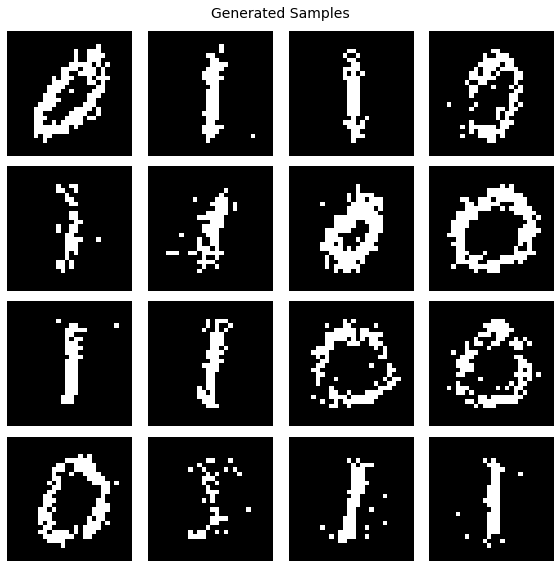

In [43]:
n_gen = 16
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, n_gen)
generated_spins = generate_sample(keys)
generated = spins_to_data(generated_spins)

n_cols, n_rows = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Samples", fontsize=14)
plt.tight_layout()
plt.show()

In [44]:
half_pixels = 14 * 28  # Top 14 rows
top_visible_nodes = visible_nodes[:half_pixels]
bottom_visible_nodes = visible_nodes[half_pixels:]

clamped_blocks = [top_visible_nodes, bottom_visible_nodes, hidden_nodes]
clamped_graph = BlockGraph(clamped_blocks, edges)
clamped_params = clamped_graph.get_sampling_params()

# Only sample bottom visible (block 1) and hidden (block 2), clamp top (block 0)
clamped_sampling_args = SamplingArgs(
    gibbs_steps=500,
    blocks_to_sample=[1, 2],
    data=clamped_params,
)

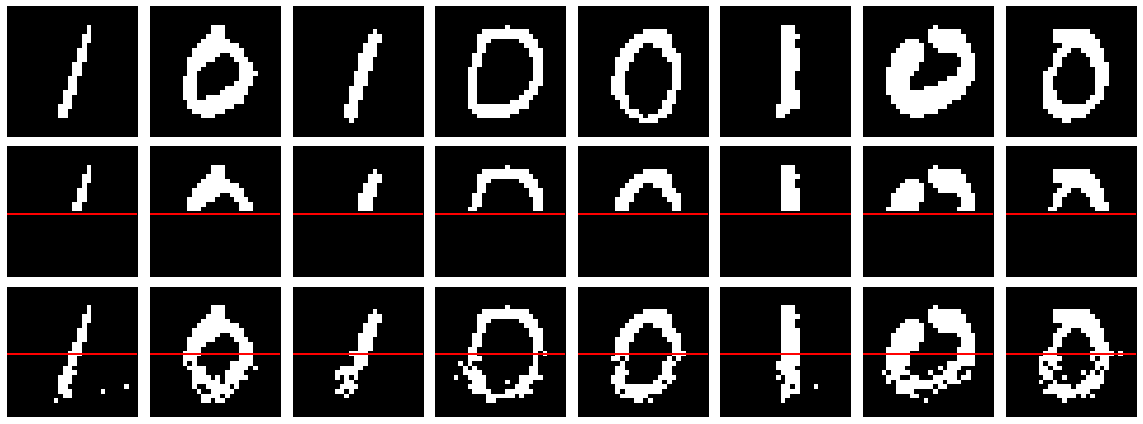

In [45]:
n_test = 8
test_batch = test_images[:n_test]


@jax.jit
@jax.vmap
def complete_image(visible_data, key):
    k1, k2, k_run = jax.random.split(key, 3)

    visible_spins = data_to_spins(visible_data).astype(jnp.int32)
    top_spins = visible_spins[:half_pixels]

    bottom_init = jax.random.choice(k1, jnp.array([-1, 1]), (n_visible - half_pixels,))
    hidden_init = jax.random.choice(k2, jnp.array([-1, 1]), (n_hidden,))

    states = sample_fn(
        [top_spins, bottom_init, hidden_init],
        [sampler, sampler, sampler],
        trained_model,
        clamped_sampling_args,
        k_run,
    )

    full_spins = jnp.concatenate([states[0][-1], states[1][-1]])
    return spins_to_data(full_spins)


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, n_test)
completed = complete_image(test_batch, keys)

fig, axes = plt.subplots(3, n_test, figsize=(16, 6))
for i in range(n_test):
    axes[0, i].imshow(test_batch[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)

    masked = test_batch[i].reshape(28, 28).copy()
    masked = jnp.array(masked).at[14:, :].set(0.5)
    axes[1, i].imshow(masked, cmap="gray", vmin=0, vmax=1)
    axes[1, i].axhline(14, color="red", linewidth=2)
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Input (top half)", fontsize=12)

    axes[2, i].imshow(completed[i].reshape(28, 28), cmap="gray")
    axes[2, i].axhline(14, color="red", linewidth=2)
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_ylabel("Completed", fontsize=12)

plt.tight_layout()
plt.show()

Data energy: -3175.77 +/- 51.00
Random energy: -332.40 +/- 123.59


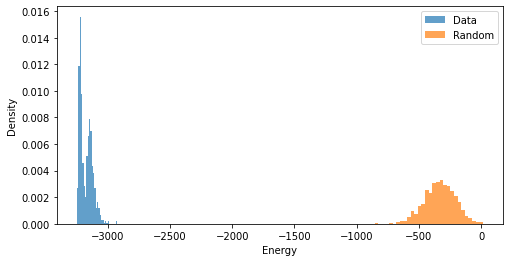

In [46]:
@jax.jit
@jax.vmap
def compute_data_energy(visible_data, key):
    visible_spins = data_to_spins(visible_data)
    hidden = jax.random.choice(key, jnp.array([-1, 1]), (n_hidden,))

    states = sample_fn(
        [visible_spins, hidden],
        [sampler, sampler],
        trained_model,
        pos_sampling_args,
        key,
    )

    state = jnp.concatenate([states[0][-1], states[1][-1]])
    return trained_model.energy(state, edge_indices, edge_mask)


n = 1000
key, subkey = jax.random.split(key)
data_keys = jax.random.split(subkey, n)
data_energies = compute_data_energy(train_images[:n], data_keys)

key, subkey = jax.random.split(key)
noise_keys = jax.random.split(subkey, n)
random_data = jax.random.bernoulli(subkey, 0.5, (n, n_visible)).astype(jnp.int32)
noise_energies = compute_data_energy(random_data, noise_keys)

print(f"Data energy: {jnp.mean(data_energies):.2f} +/- {jnp.std(data_energies):.2f}")
print(
    f"Random energy: {jnp.mean(noise_energies):.2f} +/- {jnp.std(noise_energies):.2f}"
)

plt.figure(figsize=(8, 4))
plt.hist(data_energies, bins=30, alpha=0.7, label="Data", density=True)
plt.hist(noise_energies, bins=30, alpha=0.7, label="Random", density=True)
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.show()